In [19]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [3]:
API_KEY = "QCC4AQUW1ZKX4T7P"
symbol = "AAPL"

In [4]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}&datatype=csv"

In [5]:
response = requests.get(url)

In [6]:
# print response
if response.status_code == 200:
    with open(f'{symbol}_stock_data.csv', 'wb') as file:
        file.write(response.content)
    print(f"Data saved to {symbol}_stock_data.csv")


Data saved to AAPL_stock_data.csv


In [7]:
# store the data in a pandas dataframe
df = pd.read_csv(f'{symbol}_stock_data.csv', index_col=0, parse_dates=True)

In [8]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.tail())

               open      high       low   close    volume
timestamp                                                
2025-06-27  201.890  203.2200  200.0000  201.08  73188571
2025-06-30  202.010  207.3900  199.2607  205.17  91912816
2025-07-01  206.665  210.1865  206.1401  207.82  78788867
2025-07-02  208.910  213.3400  208.1400  212.44  67941811
2025-07-03  212.145  214.6500  211.8101  213.55  34955836


In [9]:
# Add multiple indicators
df.ta.rsi(append=True)                      # RSI
df.ta.macd(append=True)                     # MACD (MACDEXT style)
df.ta.ema(length=20, append=True)           # EMA20
df.ta.sma(length=50, append=True)           # SMA50
df.ta.obv(append=True)                      # On Balance Volume
df.ta.bbands(append=True)                   # Bollinger Bands
df.ta.cci(append=True)                      # CCI
df.ta.atr(append=True)                      # ATR

# Clean up: Drop NaN values created by indicators (lookback periods)
df.dropna(inplace=True)

In [10]:
# Calculate ADX with 14-day period (default)
adx = ta.adx(df['high'], df['low'], df['close'])

# Merge into your main DataFrame
df = pd.concat([df, adx], axis=1)

# Optional: Simplify naming
df.rename(columns={
    'ADX_14': 'ADX',
    'DMP_14': 'DI+',
    'DMN_14': 'DI-'
}, inplace=True)

In [11]:
def trend_direction(row):
    if row['ADX'] > 25:
        if row['DI+'] > row['DI-']:
            return 1   # strong uptrend
        else:
            return -1  # strong downtrend
    return 0  # no clear trend

df['trend_signal'] = df.apply(trend_direction, axis=1)

In [12]:
# Calculate MA
df['MA100'] = df['close'].rolling(100).mean()
df['MA200'] = df['close'].rolling(200).mean()
df['MA_signal'] = (df['MA100'] > df['MA200']).astype(int)

# Drop NA
df = df.dropna()

In [ ]:
# 1️⃣ Select features
features = ['open', 'high', 'low', 'close', 'volume',
            'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'EMA_20', 'SMA_50', 'OBV', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
            'BBB_5_2.0', 'BBP_5_2.0', 'CCI_14_0.015', 'ATRr_14',
            'ADX', 'DI+', 'DI-', 'trend_signal', 'MA100', 'MA200', 'MA_signal']

# 2️⃣ Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# 3️⃣ Create sequences
X = []
y = []

sequence_length = 60  # last 60 days
target_col_index = features.index('close')  # we'll predict next 'close' price

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i][target_col_index])  # predicting close price

X, y = np.array(X), np.array(y)

In [30]:
# exclude the target column from X
X = np.delete(X, target_col_index, axis=2)
# print columns name of X
print("X features:", features[:target_col_index] + features[target_col_index + 1:])


X features: ['open', 'high', 'low', 'volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'EMA_20', 'SMA_50', 'OBV', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'CCI_14_0.015', 'ATRr_14', 'ADX', 'DI+', 'DI-', 'trend_signal', 'MA100', 'MA200', 'MA_signal']


In [28]:
# Feature selection should be done on the original 2D feature matrix, not on LSTM sequences
# Use only the last len(y) rows from scaled_data to match y's length
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(scaled_data[-len(y):], y)
# Get selected column names
selected_features = np.array(features)[selector.get_support()]
print("✅ Selected Features:", selected_features.tolist())

✅ Selected Features: ['open', 'high', 'low', 'EMA_20', 'SMA_50', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'MA100', 'MA200']


In [16]:
model = load_model('lstm_stock_model.h5')

193/193 [==============================] - 7s 31ms/step


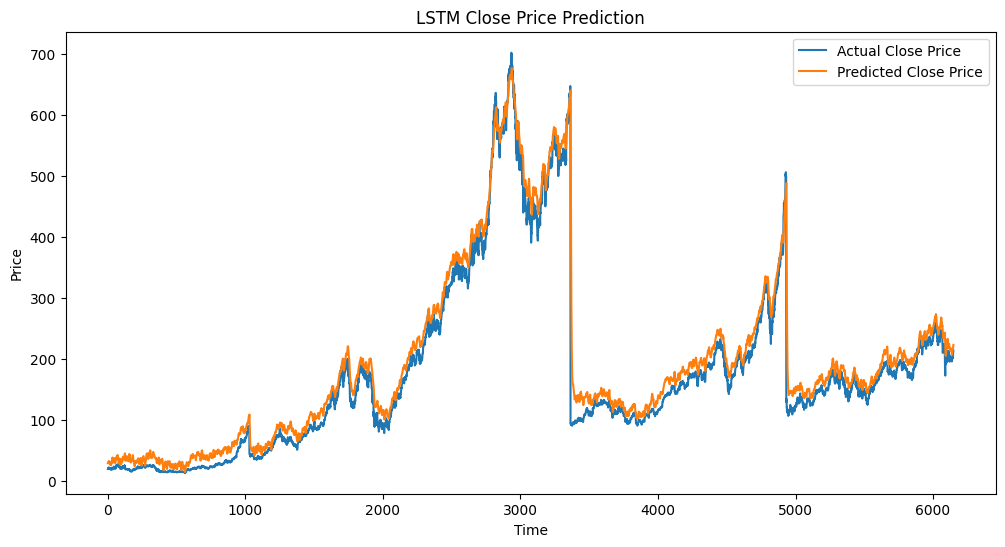

In [17]:
# Predict
y_pred = model.predict(X)

# Inverse transform (optional)
# To get actual prices, you must inverse only the close column
# So extract only that column from original scaled data
close_scaler = MinMaxScaler()
close_scaler.fit(df[['close']])
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Price')
plt.plot(y_pred_actual, label='Predicted Close Price')
plt.legend()
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [18]:
# Inverse transform to get actual prices
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y.reshape(-1, 1))

# Flatten arrays
y_pred_actual = y_pred_actual.flatten()
y_test_actual = y_test_actual.flatten()

# 1️⃣ MAE
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# 2️⃣ MSE
mse = mean_squared_error(y_test_actual, y_pred_actual)

# 3️⃣ RMSE
rmse = np.sqrt(mse)

# 4️⃣ R^2 Score
r2 = r2_score(y_test_actual, y_pred_actual)

# 5️⃣ MAPE (Optional - Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

# 🔍 Print Results
print("📊 Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error):  {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score (R2): {r2:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


📊 Evaluation Metrics:
MAE  (Mean Absolute Error): 18.6125
MSE  (Mean Squared Error):  650.7394
RMSE (Root Mean Squared Error): 25.5096
R² Score (R2): 0.9698
MAPE (Mean Absolute Percentage Error): 22.26%
